# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.022567,True,7.958663
1,-0.978900,False,-0.227778
2,0.518881,False,-0.757679
3,1.247208,False,1.240231
4,1.369491,True,3.954798
...,...,...,...
995,0.952138,True,5.668058
996,-1.059459,True,3.725037
997,0.222156,True,6.188210
998,0.661158,True,4.208314


<Axes: xlabel='v0'>

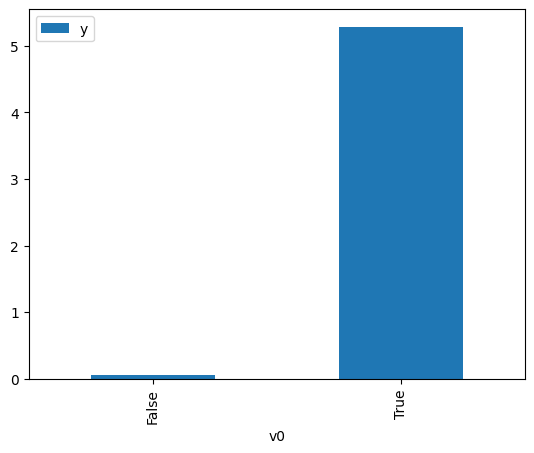

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

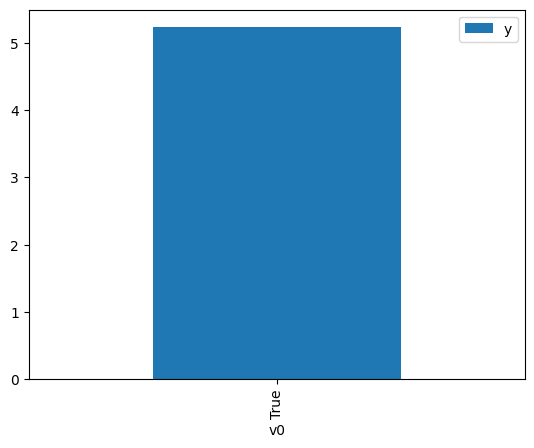

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.094358,False,0.276146,0.536275,1.864714
1,0.425225,False,-1.414499,0.483440,2.068508
2,1.944943,False,0.493480,0.335096,2.984217
3,0.521325,False,0.386106,0.473673,2.111159
4,0.493617,False,0.780960,0.476488,2.098690
...,...,...,...,...,...
995,0.008437,False,-0.216860,0.525849,1.901686
996,1.970722,False,1.112719,0.332761,3.005160
997,-0.281990,False,0.990103,0.555218,1.801095
998,1.551439,False,-0.407108,0.371694,2.690383


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.215929,True,5.339953,0.495255,2.019162
1,-1.177584,True,4.262125,0.357429,2.797757
2,0.107308,True,6.773166,0.484200,2.065261
3,-0.449053,True,6.585092,0.428048,2.336185
4,1.286003,True,4.774673,0.602728,1.659122
...,...,...,...,...,...
995,-1.244567,True,4.452741,0.351188,2.847477
996,-0.240227,True,5.856103,0.448987,2.227238
997,0.904767,True,5.602376,0.565023,1.769838
998,1.921682,True,5.446263,0.662790,1.508775


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.937
Model:                            OLS   Adj. R-squared (uncentered):              0.937
Method:                 Least Squares   F-statistic:                              7453.
Date:                Mon, 28 Aug 2023   Prob (F-statistic):                        0.00
Time:                        17:37:27   Log-Likelihood:                         -1425.6
No. Observations:                1000   AIC:                                      2855.
Df Residuals:                     998   BIC:                                      2865.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2325      0.031      7.592      0.000       0.172       0.293
x2             5.0770      0.051     99.884      0.000       4.977       5.177
==============================================================================
Omnibus:                        0.080   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.961   Jarque-Bera (JB):                0.113
Skew:                          -0.020   Prob(JB):                        0.945
Kurtosis:                       2.967   Cond. No.                         2.20
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""